In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, f1_score, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [4]:
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("filippoo/deep-learning-az-ann")
# print("Path to dataset files:", path)


In [2]:
project_path = Path(os.getcwd()).parent.absolute()
data_file_paths = [project_path/'data'/'raw'/f'Churn_Modelling_{country}.csv'  for country in ['Spain', 'France']]
# project_path

In [4]:
import pandas as pd

df = pd.concat([pd.read_csv(fpath) for fpath in data_file_paths])
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
1,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
2,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
3,15737173,Andrews,497,Spain,Male,24,3,0.00,2,1,0,76390.01,0
4,15600882,Scott,635,Spain,Female,35,7,0.00,2,1,1,65951.65,0


In [5]:
df.shape

(7491, 13)

In [ ]:
# Churn_Modelling_France.csv and Churn_Modelling_Spain.csv are just generated from the main file with country filtering/condition
# mdf = pd.read_csv("/workspaces/open-source-mlops-e2e-starting-point/data/raw/Churn_Modelling.csv")
# mdf[(mdf['Geography']=='Spain')|(mdf['Geography']=='France')]

In [6]:
# Are there missing values?
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df['Geography'].value_counts()

Geography
France    5014
Spain     2477
Name: count, dtype: int64

In [8]:
feat_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'

In [9]:
X, y = df[feat_cols], df[targ_col]

In [10]:
y.mean()

0.16326258176478442

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

clf = RandomForestClassifier(random_state=random_state, 
                            **train_params)
model = Pipeline(
    steps=[("preprocessor", SimpleImputer()), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [13]:
y_prob = model.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
f1, roc_auc

(0.5474137931034483, 0.8684327537866781)

In [14]:
reports_dir = project_path/'reports'
reports_dir.mkdir(exist_ok=True)
fig_dir = reports_dir/'figures'
fig_dir.mkdir(exist_ok=True)

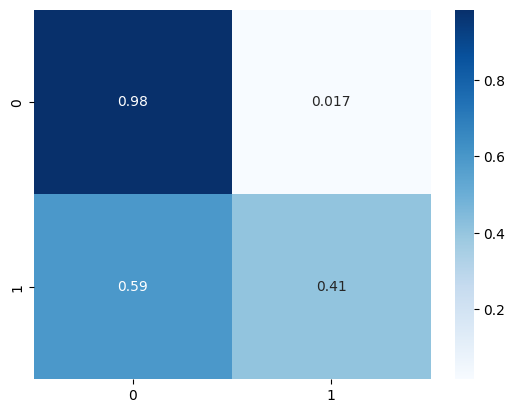

In [15]:
cm = confusion_matrix(y_test, y_pred, normalize='true') 
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.savefig(fig_dir/'cm.png')

In [16]:
out_feat_names = model[:-1].get_feature_names_out(feat_cols)
out_feat_names

array(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], dtype=object)

In [17]:
import eli5
from sklearn.metrics import make_scorer
from eli5.sklearn import PermutationImportance


preprocessor = model.named_steps['preprocessor']
clf = model.named_steps['clf']
X_test_transformed = preprocessor.transform(X_test)

perm = PermutationImportance(clf, scoring=make_scorer(f1_score), random_state=random_state).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names=out_feat_names)

Weight,Feature
0.2444 ± 0.0285,Age
0.1816 ± 0.0108,NumOfProducts
0.1365 ± 0.0315,IsActiveMember
0.0326 ± 0.0050,Balance
0.0215 ± 0.0136,Tenure
0.0143 ± 0.0118,CreditScore
0.0063 ± 0.0135,EstimatedSalary
0.0002 ± 0.0083,HasCrCard


In [19]:
feat_imp = zip(X_test.columns.tolist(), perm.feature_importances_)
df_feat_imp = pd.DataFrame(feat_imp, 
                    columns=['feature', 'importance'])
df_feat_imp = df_feat_imp.sort_values(by='importance', ascending=False)
df_feat_imp

,feature,importance
1,Age,0.244377
4,NumOfProducts,0.181561
6,IsActiveMember,0.136543
3,Balance,0.032561
2,Tenure,0.021488
0,CreditScore,0.014311
7,EstimatedSalary,0.006291
5,HasCrCard,0.000152


In [23]:
feat_importance_fpath = reports_dir/'feat_imp.csv'
df_feat_imp.to_csv(feat_importance_fpath, index=False)

In [24]:
model

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [25]:
from joblib import dump

models_dir = project_path/'models'
models_dir.mkdir(exist_ok=True)
dump(model, models_dir/'clf-model.joblib')

['/workspaces/open-source-mlops-e2e-starting-point/models/clf-model.joblib']